# Importing Libraries

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np
from sklearn.utils import resample
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# DATASET LOADING AND RESTRUCTURING

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Bracu/Summer 2022/CSE422/olid-training-v1.0.tsv', sep="\t")
df = df.drop(['id','subtask_b', 'subtask_c'], axis=1)
df.rename(columns = {'subtask_a':'label'}, inplace = True)


In [ ]:
df

,tweet,label
0,@USER She should ask a few native Americans wh...,OFF
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF
2,Amazon is investigating Chinese employees who ...,NOT
3,"@USER Someone should'veTaken"" this piece of sh...",OFF
4,@USER @USER Obama wanted liberals &amp; illega...,NOT
...,...,...
13235,@USER Sometimes I get strong vibes from people...,OFF
13236,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT
13237,@USER And why report this garbage. We don't g...,OFF
13238,@USER Pussy,OFF


# DATASET PREPROCESSING

## Shuffling Dataset After Balancing

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df

,tweet,label
0,Absolutely all fucking done. Bye Felicia URL,OFF
1,@USER Guys ugly and unhinged.,OFF
2,@USER @USER @USER Don’t get on here saying tha...,OFF
3,@USER Carrey is a sick man!!!,OFF
4,@USER @USER @USER Just another BLM brat blocki...,OFF
...,...,...
17675,@USER yup fooled antifa threw big ol' fire pit...,OFF
17676,@USER You are on the middle between regular st...,NOT
17677,@USER @USER She is useless. Attempts to do th...,OFF
17678,@USER Didn’t break rules. Had permission. A liar.,NOT


## Encoding the label

In [ ]:
def label_encoder(x):
    if x == 'NOT': return 0
    else: return 1

In [ ]:
df['label'] = df.label.apply(lambda x: label_encoder(x))

In [ ]:
df

,tweet,label
0,Absolutely all fucking done. Bye Felicia URL,1
1,@USER Guys ugly and unhinged.,1
2,@USER @USER @USER Don’t get on here saying tha...,1
3,@USER Carrey is a sick man!!!,1
4,@USER @USER @USER Just another BLM brat blocki...,1
...,...,...
17675,@USER yup fooled antifa threw big ol' fire pit...,1
17676,@USER You are on the middle between regular st...,0
17677,@USER @USER She is useless. Attempts to do th...,1
17678,@USER Didn’t break rules. Had permission. A liar.,0


## Preprocessing in input text


* removed link
* removed linebreaks
* removed extra spaces
* removed punctuation
* removed stopwords
* stemming
* lowercased the tweet
* extracted hashtags and added at the end of the sentence



In [ ]:
df['tweet'][25]

'Montana restaurant denies #DonJr use of its facility for campaign rally.  #DonaldTrumpJr #WednesdayWisdom #TheResistance #MAGA #Trump #FoxNews #Resist #ImpeachTrump URL'

In [ ]:
port_stem = PorterStemmer()
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [ ]:
def clean_text(x):
    x = re.sub(r'https?://\S+', '', x) 
    x = re.sub(r'#\w+', '', x) 
    x = re.sub(r'\n',' ',x) 
    x = re.sub('\s+', ' ', x).strip()
    x = re.sub('\.','',x) 
    for p in string.punctuation:
        x = re.sub('\{}'.format(p),'',x)
    return x.lower()
    
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or ''

def pre_process_text(df):
    stop = stopwords.words('english')
    df['clean_tweet'] = df['tweet'].apply(lambda x: clean_text(x))
    df['clean_tweet'] = df['clean_tweet'].apply(stemming)
    df['hashtags'] = df['tweet'].apply(lambda x: find_hashtags(x))
    df['clean_tweet_without_stopword'] = df['clean_tweet'].apply(lambda x:' '.join([word for word in x.split() if word not in stop]))
    df['final'] = df['clean_tweet_without_stopword']+" "+df['hashtags']
    return df

In [ ]:
pdf = pre_process_text(df)
pdf

,tweet,label,clean_tweet,hashtags,clean_tweet_without_stopword,final
0,Absolutely all fucking done. Bye Felicia URL,1,absolut fuck done bye felicia url,,absolut fuck done bye felicia url,absolut fuck done bye felicia url
1,@USER Guys ugly and unhinged.,1,user guy ugli unhing,,user guy ugli unhing,user guy ugli unhing
2,@USER @USER @USER Don’t get on here saying tha...,1,user user user get say type dumb shit,,user user user get say type dumb shit,user user user get say type dumb shit
3,@USER Carrey is a sick man!!!,1,user carrey sick man,,user carrey sick man,user carrey sick man
4,@USER @USER @USER Just another BLM brat blocki...,1,user user user anoth blm brat block highway an...,,user user user anoth blm brat block highway an...,user user user anoth blm brat block highway an...
...,...,...,...,...,...,...
17675,@USER yup fooled antifa threw big ol' fire pit...,1,user yup fool antifa threw big ol fire pit roc...,,user yup fool antifa threw big ol fire pit roc...,user yup fool antifa threw big ol fire pit roc...
17676,@USER You are on the middle between regular st...,0,user middl regular stretcher bariatr,,user middl regular stretcher bariatr,user middl regular stretcher bariatr
17677,@USER @USER She is useless. Attempts to do th...,1,user user useless attempt right thing never fo...,,user user useless attempt right thing never fo...,user user useless attempt right thing never fo...
17678,@USER Didn’t break rules. Had permission. A liar.,0,user break rule permiss liar,,user break rule permiss liar,user break rule permiss liar


## Vectorizing the text in TF-IDF vectorizer (Trigram)

In [ ]:
tf_idf = TfidfVectorizer(ngram_range=(1,3))
X = tf_idf.fit_transform(pdf['final'])
Y = pdf.label


# SPLITING THE DATASET

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle = True)

## BALANCING THE DATASET

In [ ]:
df['label'].value_counts()

NOT    8840
OFF    4400
Name: label, dtype: int64

### Before Balancing The Dataset

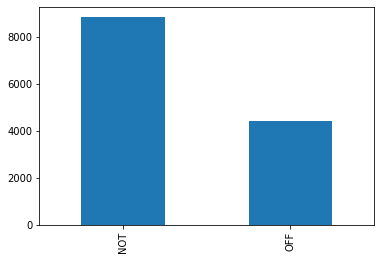

In [ ]:
df['label'].value_counts().plot(kind = 'bar', label = ('Not Offensive', "Offensive"))


In [ ]:
def balance_dataset(data):
  data_offensive = data[(data['label']=='OFF')]
  data_not_offensive = data[(data['label']=='NOT')]
  data_offensive_oversampled = resample(data_offensive, replace = True, n_samples = data['label'].value_counts()[0], random_state = 42)
  balanced_dataset = pd.concat([data_offensive_oversampled,data_not_offensive]).reset_index(drop=True)
  return balanced_dataset

In [ ]:
X_Train = balance_dataset(df)
df['label'].value_counts()

OFF    8840
NOT    8840
Name: label, dtype: int64

### After Balancing the Dataset

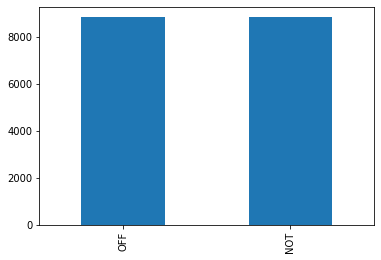

In [ ]:
df['label'].value_counts().plot(kind = 'bar', label = ('Not Offensive', "Offensive"))

In [ ]:
df

,tweet,label
0,A videographer who reported on the violence of...,OFF
1,@USER I love it that the wet liberals are so f...,OFF
2,@USER @USER Indoctrinated 🐑 programmed to beli...,OFF
3,@USER No one is open! You think he is sitting ...,OFF
4,@USER @USER The Pope is complicit. Make no m...,OFF
...,...,...
17675,@USER She is not the brightest light on the tree.,NOT
17676,@USER 😂😂😂😂😂😂 if I say you are mad now you will...,NOT
17677,@USER @USER @USER @USER @USER @USER @USER @USE...,NOT
17678,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT


# TRAINING THE MACHINE LEARNING MODEL


1.   Logistic Regression
2.   Support Vector Machine
3.   Naive Bayes



In [ ]:
model_LR = LogisticRegression().fit(X_train,Y_train)
model_SVM = SVC(kernel='rbf', random_state = 42).fit(X_train, Y_train)
model_NB = ComplementNB().fit(X_train,Y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
model_RF = RandomForestClassifier(n_estimators= 100, criterion="entropy").fit(X_train, Y_train)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model_DC = DecisionTreeClassifier(criterion = 'entropy', random_state = 1).fit(X_train,Y_train)

# SCORE ON TEST SET

In [ ]:
LR_score = classification_report(Y_test, model_LR.predict(X_test))
SVC_score = classification_report(Y_test, model_SVM.predict(X_test))
NB_score = classification_report(Y_test, model_NB.predict(X_test))
RF_score = classification_report(Y_test, model_RF.predict(X_test))
print("LOGISTIC REGRESSION")
print(LR_score)
print("SUPPORT VECTOR CLASSIFICATION")
print(SVC_score)
print("NAIVE BAYES CLASSIFICATION")
print(NB_score)
print("RANDOM FOREST CLASSIFICATION")
print(RF_score)

LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1748
           1       0.89      0.83      0.86      1788

    accuracy                           0.86      3536
   macro avg       0.86      0.86      0.86      3536
weighted avg       0.86      0.86      0.86      3536

SUPPORT VECTOR CLASSIFICATION
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      1748
           1       0.98      0.83      0.90      1788

    accuracy                           0.91      3536
   macro avg       0.92      0.91      0.91      3536
weighted avg       0.92      0.91      0.91      3536

NAIVE BAYES CLASSIFICATION
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1748
           1       0.76      0.92      0.83      1788

    accuracy                           0.82      3536
   macro avg       0.83      0.81      0.81      35

In [ ]:
DC_score = classification_report(Y_test, model_DC.predict(X_test))
print("LOGISTIC REGRESSION")
print(DC_score)

LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1748
           1       0.84      0.90      0.87      1788

    accuracy                           0.86      3536
   macro avg       0.86      0.86      0.86      3536
weighted avg       0.86      0.86      0.86      3536

